# **competition (dog vs cat)**

## Import libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import pandas as pd


## Get the data

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle competitions download -c dogs-vs-cats

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

test1 = zipfile.ZipFile('test1.zip')
test1.extractall()
test1.close()

In [5]:
train = zipfile.ZipFile('train.zip')
train.extractall()
train.close()

In [6]:
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 25000 images in 'train'.


In [7]:
for dirpath, dirnames, filenames in os.walk("test1"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 12500 images in 'test1'.


## Display images

In [8]:
import matplotlib.image as mpimg
import random

def view_random_image(target_dir):

  # Get a random image path
  random_image = random.sample(os.listdir(target_dir), 1)
  print([random_image])
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_dir +'/'+ random_image[0])
  plt.imshow(img)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

[['dog.722.jpg']]
Image shape: (416, 447, 3)


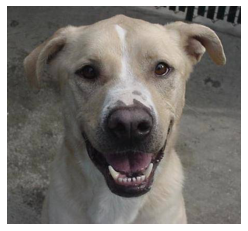

In [9]:
pic = view_random_image('/content/train')

In [10]:
pic.max()

255

## data processing

In [11]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

data = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [12]:
data.tail()

,filename,category
24995,cat.4787.jpg,cat
24996,cat.7583.jpg,cat
24997,dog.10897.jpg,dog
24998,dog.12252.jpg,dog
24999,cat.11677.jpg,cat


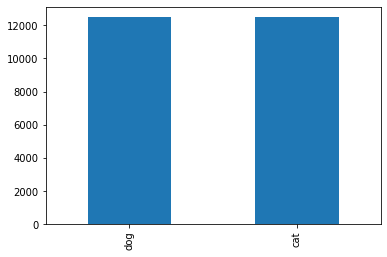

In [13]:
data['category'].value_counts().plot.bar()


### Split the dataset


In [14]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
train_df.head()

,filename,category
23311,dog.12303.jpg,dog
23623,dog.4664.jpg,dog
1020,cat.12326.jpg,cat
12645,cat.699.jpg,cat
1533,dog.1644.jpg,dog


In [16]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [17]:
train_df.head()

,filename,category
0,dog.12303.jpg,dog
1,dog.4664.jpg,dog
2,cat.12326.jpg,cat
3,cat.699.jpg,cat
4,dog.1644.jpg,dog


## Train the model

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense

In [19]:
train_gen = ImageDataGenerator(rescale=1/255.,
                               rotation_range=0.2,
                               shear_range=0.1,
                               zoom_range=0.2,
                               width_shift_range=0.15,
                               height_shift_range=0.15,
                               vertical_flip=True
                               )
test_gen = ImageDataGenerator(rescale=1/255.)


train_data = train_gen.flow_from_dataframe(train_df,
                                           "train",
                                           x_col='filename', 
                                           y_col='category',
                                           target_size=(150,150),
                                           class_mode='binary',
                                           batch_size=32
                                          )
test_data = test_gen.flow_from_dataframe(valid_df,
                                         "train",
                                         x_col='filename', 
                                         y_col='category',
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=32
                                        )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [20]:
model = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(150, 150, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 10)        910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11560)             0

In [23]:
history = model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=0.3 * len(train_data),
                        validation_data=test_data,
                        validation_steps=0.2 * len(test_data))

Epoch 1/10
187/187 [==============================] - 55s 293ms/step - loss: 0.6923 - accuracy: 0.5306 - val_loss: 0.6924 - val_accuracy: 0.5029
Epoch 2/10
187/187 [==============================] - 54s 290ms/step - loss: 0.6823 - accuracy: 0.5723 - val_loss: 0.6592 - val_accuracy: 0.6289
Epoch 3/10
187/187 [==============================] - 54s 289ms/step - loss: 0.6534 - accuracy: 0.6179 - val_loss: 0.6090 - val_accuracy: 0.6719
Epoch 4/10
187/187 [==============================] - 54s 290ms/step - loss: 0.6282 - accuracy: 0.6488 - val_loss: 0.6137 - val_accuracy: 0.6387
Epoch 5/10
187/187 [==============================] - 54s 290ms/step - loss: 0.6117 - accuracy: 0.6695 - val_loss: 0.6144 - val_accuracy: 0.6670
Epoch 6/10
187/187 [==============================] - 55s 291ms/step - loss: 0.5959 - accuracy: 0.6772 - val_loss: 0.5983 - val_accuracy: 0.6787
Epoch 7/10
187/187 [==============================] - 54s 290ms/step - loss: 0.5860 - accuracy: 0.6795 - val_loss: 0.5751 - val_ac

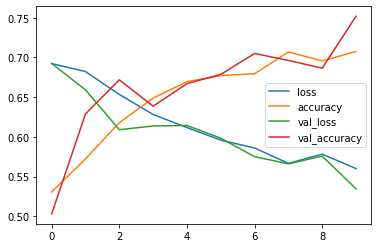

In [24]:
pd.DataFrame(history.history).plot()

# Train model using transform learning


In [25]:
import tensorflow_hub as hub

In [26]:
train_gen_tl = ImageDataGenerator(rescale=1/255.
                               )
test_gen_tl = ImageDataGenerator(rescale=1/255.)


train_data_tl = train_gen_tl.flow_from_dataframe(train_df,
                                           "train",
                                           x_col='filename', 
                                           y_col='category',
                                           target_size=(150,150),
                                           class_mode='binary',
                                           batch_size=32
                                          )
test_data_tl = test_gen_tl.flow_from_dataframe(valid_df,
                                         "train",
                                         x_col='filename', 
                                         y_col='category',
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=32
                                        )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [27]:
model_tl = Sequential([
  hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                 trainable=False),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_tl.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history2 = model_tl.fit(train_data_tl,
                        epochs=3,
                        steps_per_epoch= 0.3 * len(train_data_tl),
                        validation_data=test_data_tl,
                        validation_steps= 0.2 * len(test_data_tl))

Epoch 1/3
187/187 [==============================] - 37s 146ms/step - loss: 0.1609 - accuracy: 0.9579 - val_loss: 0.0710 - val_accuracy: 0.9824
Epoch 2/3
187/187 [==============================] - 26s 139ms/step - loss: 0.0664 - accuracy: 0.9796 - val_loss: 0.0579 - val_accuracy: 0.9766
Epoch 3/3
187/187 [==============================] - 26s 139ms/step - loss: 0.0519 - accuracy: 0.9835 - val_loss: 0.0621 - val_accuracy: 0.9775


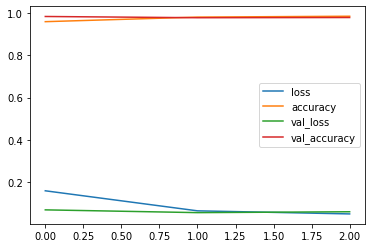

In [28]:
pd.DataFrame(history2.history).plot()

In [29]:
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


# Predict on test dataset downloaded from kaggle


In [30]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(150,150),
    batch_size=32,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
predict = model_tl.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [33]:
# test_df['category'] = np.argmax(predict, axis=-1)